# Loading Dependencies

In [5]:
#Loading Dependencies

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import h5py
import os
import sklearn as sk
from sklearn.decomposition import PCA
from timeit import default_timer as timer


from PIL import Image
from IPython.display import display


work_dir = os.getcwd()
print('Current working directory:')
print(work_dir)




print(os.listdir("./data"))

Current working directory:
C:\Users\thorb\COMP5328_Project2
['CIFAR.npz', 'FashionMNIST0.5.npz', 'FashionMNIST0.6.npz']


# Loading Data

## 1. Fashion MNIST0.5 

In [6]:
data1 = np.load(work_dir + "./data/FashionMNIST0.5.npz")
X_train1 = data1['Xtr']
Y_train1 = data1['Str']
X_test1 = data1['Xts']
Y_test1 = data1['Yts']

X_train1.shape, Y_train1.shape, X_test1.shape, Y_test1.shape

((18000, 28, 28), (18000,), (3000, 28, 28), (3000,))

In [7]:
set(Y_train1)

{0, 1, 2}

In [8]:
for k in np.random.randint(18000, size=10):
    X_image = X_train1[k]
    display(Image.fromarray(X_image))


## 2. MNIST 0.6

In [9]:
data2 = np.load(work_dir + "./data/FashionMNIST0.6.npz")
X_train2 = data2['Xtr']
Y_train2 = data2['Str']
X_test2 = data2['Xts']
Y_test2 = data2['Yts']

X_train2.shape, Y_train2.shape, X_test2.shape, Y_test2.shape

((18000, 28, 28), (18000,), (3000, 28, 28), (3000,))

In [10]:
set(Y_train2)

{0, 1, 2}

In [11]:
for k in np.random.randint(18000, size=10):
    X_image = X_train2[k]
    display(Image.fromarray(X_image))


# CIFAR

In [12]:
data3 = np.load(work_dir + "./data/CIFAR.npz")
X_train3 = data3['Xtr']
Y_train3 = data3['Str']
X_test3 = data3['Xts']
Y_test3 = data3['Yts']

X_train3.shape, Y_train3.shape, X_test3.shape, Y_test3.shape

((15000, 32, 32, 3), (15000,), (3000, 32, 32, 3), (3000,))

In [13]:
set(Y_train3)

{0, 1, 2}

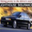

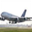

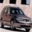

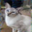

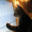

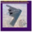

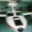

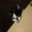

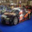

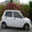

In [14]:
for k in np.random.randint(15000, size=10):
    X_image = X_train3[k]
    display(Image.fromarray(X_image))

## Preprocessing

In [156]:
def encode(Y):
    n,c = Y.size, 3
    Y_encoded = np.zeros((n,c))
    
    for i in range(n):
        Y_encoded[i,Y[i]] = 1
    
    return Y_encoded
    
    

In [16]:
encode(Y_train1).shape

(18000, 3)

# Models

## Multinomial

In [42]:
### testing with sklearn


from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter = 10000).fit(X, Y)

In [43]:
len(np.where(clf.predict(X)==Y)[0])

919

## Completely new Multinomial Grad Descent

In [119]:
#Returns softmax values for n vectors of dimension c
def softmax(array):
    n,c = array.shape
    temp = np.exp(array)
    temp2 = temp.sum(axis = 1)
    
    return temp/temp2.reshape(n,1)  #Division row wise

In [171]:
def mu(X,W):
    XW = X@W
    
    return softmax(XW)

In [190]:
# Returns the gradient of the cross error entropy function in W (as per Murphy)
# X nxp
# W pxC
# Y (encoded) nxC
def ceef_grad(X,W,Y):
    Y = encode(Y)
    mu_matrix = mu(X,W) #nxc
    n,p = X.shape
    p,c = W.shape

    grad = np.zeros((p,c))
    for i in range(n):
        grad += np.transpose(np.kron((mu_matrix[i,:] - Y[i,:]),X[i,:]).reshape(c,p))
        #reshape: reshapes a matrix by filling up rows first, we need columns first, thus the transpose with interchange p,c
    
    return grad/n    



In [200]:

##### ADJUST THIS
def softmax_fit2(X, W, y, lr = 0.01, nepoches = 100, tol = 1e-5, batch_size = 10):
    W_old = W.copy()
    ep = 0 
    N = X.shape[0]
    nbatches = int(np.ceil(float(N)/batch_size))
    while ep < nepoches: 
        print("iteration:" + str(ep))
        ep += 1 
        mix_ids = np.random.permutation(N) # mix data 
        for i in range(nbatches):
            # get the i-th batch
            batch_ids = mix_ids[batch_size*i:min(batch_size*(i+1), N)] 
            X_batch, y_batch = X[batch_ids], y[batch_ids]
            W -= lr*ceef_grad(X_batch,W, y_batch) # update gradient descent # TODO
        
        print("Diff: " + str(np.linalg.norm(W - W_old)/W.size))
        
        if np.linalg.norm(W - W_old)/W.size < tol:
            break 
        W_old = W.copy()
    return W


In [194]:
def multinomial_grad_descent(X,W,Y,eta,max_iter,tol):    
    grad = ceef_grad(X,W,Y)
    diff = np.linalg.norm(eta * grad)
    iter = 0
    
    while (diff > tol) and iter < max_iter:
        W_old = W.copy()
        
        if iter%20 == 0:
            print('Iter:' + str(iter))
            print('Current diff' + str(diff))
        
        W = W - eta * grad
        
        #new gradient:
        grad = ceef_grad(X,W,Y)
        #new diff:
        diff = (np.linalg.norm(W - W_old))/W.size
        iter += 1
        print(diff)
        
    return W
    

In [192]:
#X nxp
#W pxc

def get_predictions(X,W):
    n,p = X.shape
    predictions = np.zeros(n)
    
    mu_matrix = mu(X,W)
    for i in range(n):
        predictions[i] = np.argmax(mu_matrix[i,:])
    
    return predictions  

### Tests:

In [197]:
X = scaler.fit_transform(X_train1[:1000,:].reshape(1000,28*28))
Y = Y_train1[:1000]
#W = np.random.randint(5,size=(28*28,3))
W =  0.01* np.random.rand(28*28,3)

C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [201]:
W1 = softmax_fit2(X,W,Y)

iteration:0
Diff: 0.00018831923077746078
iteration:1
Diff: 0.0001246701934723679
iteration:2
Diff: 0.00010338217451650772
iteration:3
Diff: 0.00010602931592071802
iteration:4
Diff: 9.647513479506107e-05
iteration:5
Diff: 8.676598764070488e-05
iteration:6
Diff: 8.872195546622779e-05
iteration:7
Diff: 8.75541648565917e-05
iteration:8
Diff: 7.581624058982594e-05
iteration:9
Diff: 7.683178651908192e-05
iteration:10
Diff: 6.938375092969417e-05
iteration:11
Diff: 7.81737343412486e-05
iteration:12
Diff: 7.116753967128027e-05
iteration:13
Diff: 6.608669525914494e-05
iteration:14
Diff: 6.047439226498809e-05
iteration:15
Diff: 5.901674280226644e-05
iteration:16
Diff: 5.7420081908394634e-05
iteration:17
Diff: 6.259164905279302e-05
iteration:18
Diff: 6.409960970513822e-05
iteration:19
Diff: 5.963057943895684e-05
iteration:20
Diff: 6.106681739716469e-05
iteration:21
Diff: 5.744897728173074e-05
iteration:22
Diff: 5.9867079805091885e-05
iteration:23
Diff: 5.192931690346384e-05
iteration:24
Diff: 4.91

In [202]:
len(np.where(get_predictions(X,W1)==Y)[0])

795

In [203]:
W2 = multinomial_grad_descent(X,W,Y,eta = 0.01,max_iter=1000,tol = 10e-5)

Iter:0
Current diff0.006302577678467894
2.6796673803009718e-06


In [204]:
len(np.where(get_predictions(X,W2)==Y)[0])

802

### blabla


In [115]:
def Softmax2(Z): # TODO
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 1, keepdims = True)
    return A

In [130]:
# calculate gradient 
def softmax_grad(X, y, W):
    A = Softmax(X.dot(W))    # shape of (N, C)
    id0 = range(X.shape[0])  # number of train data
    A[id0, y] -= 1           # A - Y, shape of (N, C)
    return X.T.dot(A)/X.shape[0]
    '''
    onehot = np.zeros((len(y), C ))
    onehot[np.arange(len(y)), y] = 1
    A = softmax_stable(x.dot(W))
    A = A - onehot
    x.T.dot(A2)/x.shape[0]
    '''

In [106]:
# cost or loss function  
def softmax_loss(X, y, W):
    A = Softmax(X.dot(W))
    id0 = range(X.shape[0])
    return -np.mean(np.log(A[id0, y]))

In [107]:
# building learning function using softmax gradient descent
def softmax_fit(X, y, W, lr = 0.01, nepoches = 100, tol = 1e-5, batch_size = 10):
    W_old = W.copy()
    ep = 0 
    loss_hist = [softmax_loss(X, y, W)] # store history of loss 
    N = X.shape[0]
    nbatches = int(np.ceil(float(N)/batch_size))
    while ep < nepoches: 
        print("iteration:" + str(ep))
        
        ep += 1 
        mix_ids = np.random.permutation(N) # mix data 
        for i in range(nbatches):
            # get the i-th batch
            batch_ids = mix_ids[batch_size*i:min(batch_size*(i+1), N)] 
            X_batch, y_batch = X[batch_ids], y[batch_ids]
            W -= lr*softmax_grad(X_batch, y_batch, W) # update gradient descent # TODO
        loss_hist.append(softmax_loss(X, y, W))
        
        print("Diff: " + str(np.linalg.norm(W - W_old)/W.size))
        
        if np.linalg.norm(W - W_old)/W.size < tol:
            break 
        W_old = W.copy()
    return W, loss_hist 

# predict function
def pred(W, X):
    A = Softmax(X.dot(W))
    return np.argmax(A, axis = 1)

In [108]:
X = scaler.fit_transform(X_train1[:1000,:].reshape(1000,28*28))
Y = Y_train1[:1000]
#W = np.random.randint(5,size=(28*28,3))
W =  0.01* np.random.rand(28*28,3)

W = softmax_fit(X,Y, W,)[0]

C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


iteration:0
Diff: 0.00018175009801899697
iteration:1
Diff: 0.0001271231887514532
iteration:2
Diff: 0.00012174841937629206
iteration:3
Diff: 0.00010727115540232975
iteration:4
Diff: 9.184768124563403e-05
iteration:5
Diff: 8.352339017473348e-05
iteration:6
Diff: 8.018186644665936e-05
iteration:7
Diff: 7.688046051936695e-05
iteration:8
Diff: 7.294802341756877e-05
iteration:9
Diff: 6.940364627994282e-05
iteration:10
Diff: 6.961844710308487e-05
iteration:11
Diff: 6.892273410033972e-05
iteration:12
Diff: 7.324088490771107e-05
iteration:13
Diff: 7.041670760507992e-05
iteration:14
Diff: 5.8545646139522254e-05
iteration:15
Diff: 6.531835091090147e-05
iteration:16
Diff: 6.786311355180392e-05
iteration:17
Diff: 6.477438939742916e-05
iteration:18
Diff: 6.648661208639878e-05
iteration:19
Diff: 7.104360243081373e-05
iteration:20
Diff: 5.792669943926511e-05
iteration:21
Diff: 7.03403783981781e-05
iteration:22
Diff: 6.468507970826617e-05
iteration:23
Diff: 6.964023024410256e-05
iteration:24
Diff: 5.88